# Word Embeddings + various classification algorithms

In [60]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
import gensim
from transformers import GPT2LMHeadModel
from transformers import GPT2Tokenizer

import time
import csv
from tqdm import tqdm
from bs4 import BeautifulSoup
import re, string
import nltk
from nltk.corpus import stopwords
import pickle
from tabulate import tabulate

import xgboost as xgb

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score, roc_auc_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [22]:
train = pd.read_csv('../../data/liar_dataset/train.tsv', sep="\t", usecols=[1, 2], names = ["label", "text"])
test = pd.read_csv('../../data/liar_dataset/test.tsv', sep="\t", usecols=[1, 2], names = ["label", "text"])
valid = pd.read_csv('../../data/liar_dataset/valid.tsv', sep="\t", usecols=[1, 2], names = ["label", "text"])

train = pd.concat([train, valid])

In [23]:
train['label'].value_counts()

half-true      2362
false          2258
mostly-true    2213
barely-true    1891
true           1845
pants-fire      955
Name: label, dtype: int64

In [24]:
convert_text_labels = lambda x: 0 if x in ['true', 'mostly-true'] else 1

In [25]:
train['label'] = train['label'].apply(convert_text_labels)
test['label'] = test['label'].apply(convert_text_labels)

In [26]:
train['label'].value_counts()

1    7466
0    4058
Name: label, dtype: int64

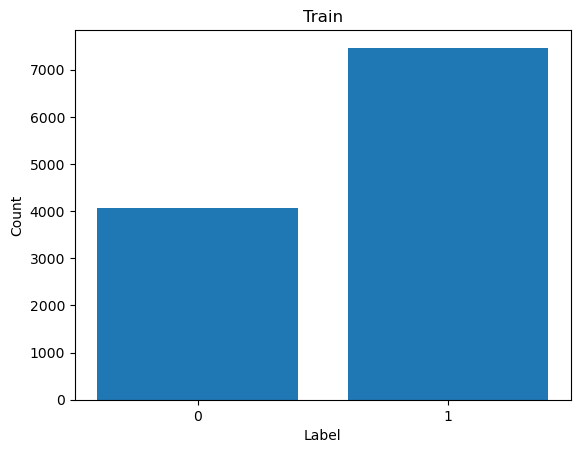

In [27]:
plt.bar(train['label'].value_counts().index, train['label'].value_counts().values)

plt.xticks(train['label'].value_counts().index)

plt.title('Train')
plt.xlabel('Label')
plt.ylabel('Count')

plt.show()

In [28]:
test['label'].value_counts()

1    818
0    449
Name: label, dtype: int64

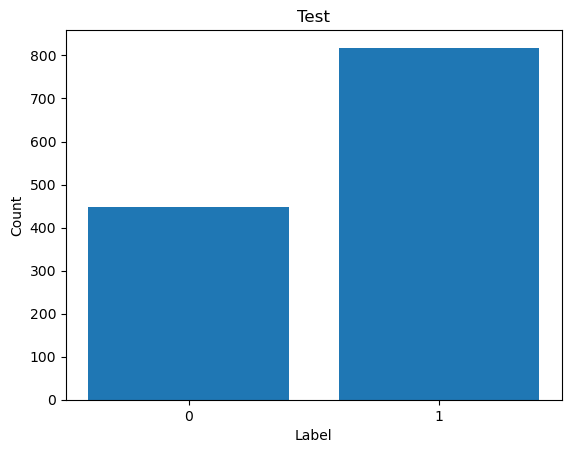

In [29]:
plt.bar(test['label'].value_counts().index, test['label'].value_counts().values)

plt.xticks(test['label'].value_counts().index)

plt.title('Test')
plt.xlabel('Label')
plt.ylabel('Count')

plt.show()

In [30]:
train['text'].str.len().describe()

count    11524.000000
mean       106.895783
std         58.415051
min         11.000000
25%         73.000000
50%         99.000000
75%        133.000000
max       3192.000000
Name: text, dtype: float64

In [31]:
test['text'].str.len().describe()

count    1267.000000
mean      109.578532
std        98.031030
min        12.000000
25%        74.000000
50%        98.000000
75%       133.000000
max      2941.000000
Name: text, dtype: float64

In [32]:
# # OLD data
# fake = pd.read_csv('../../data/Fake.csv')
# true = pd.read_csv('../../data/True.csv')
#
# fake["label"] = 0
# true["label"] = 1
#
# df = pd.concat([fake, true], ignore_index = True)
#
# df['text'] = df['title'] + " " + df['text']
# df.drop(columns=['title', 'date', 'subject'], inplace = True)

In [33]:
%%time
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)


def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    text = re.sub('\[[^]]*\]', '', text)
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
    
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

train['text']=train['text'].apply(denoise_text)
test['text']=test['text'].apply(denoise_text)

train.to_csv("../../data/train.csv", index=False)
test.to_csv("../../data/test.csv", index=False)


X_train = train['text'].tolist()
y_train = train['label'].tolist()
with open("../../data/X_train", "wb") as fp:
    pickle.dump(X_train, fp)
with open("../../data/y_train", "wb") as fp:
    pickle.dump(y_train, fp)

X_test = test['text'].tolist()
y_test = test['label'].tolist()
with open("../../data/X_test", "wb") as fp:
    pickle.dump(X_test, fp)
with open("../../data/y_test", "wb") as fp:
    pickle.dump(y_test, fp)


train_small = train.sample(frac=1).reset_index(drop=True)[:1000]
train_small.to_csv("../../data/train_small.csv", index=False)

X_train_small = train_small['text'].tolist()
y_train_small = train_small['label'].tolist()
with open("../../data/small/X_train", "wb") as fp:
    pickle.dump(X_train_small, fp)
with open("../../data/small/y_train", "wb") as fp:
    pickle.dump(y_train_small, fp)
with open("../../data/small/X_test", "wb") as fp:
    pickle.dump(X_test, fp)
with open("../../data/small/y_test", "wb") as fp:
    pickle.dump(y_test, fp)

[nltk_data] Downloading package stopwords to /home/szymon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/szymon/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


CPU times: user 846 ms, sys: 15.1 ms, total: 861 ms
Wall time: 1.07 s


---

Reduce dataset for testing purposes

In [34]:
# df_original = df.copy()
# df = df.sample(frac=1).reset_index(drop=True)[:1000]

---

# Embedding

In [35]:
redo_embedding = False # recalculate embeddings
fast = True # True if use reduced dataset (1000 obs) vs. False if full dataset (40000 obs)

In [36]:
%%time
# Load data

# OLD approach ------------------------
# if fast:
#     df_original = df.copy()
#     df = df.sample(frac=1).reset_index(drop=True)[:1000]
#
# if redo_embedding:
#     X = df['text'].tolist()
#     y = df['label'].tolist()
#
#     with open("X", "wb") as fp:
#       pickle.dump(X, fp)
#     with open("y", "wb") as fp:
#       pickle.dump(y, fp)
# elif fast:
#     with open("../../data/small/X", "rb") as fp:
#       X = pickle.load(fp)
#     with open("../../data/small/y", "rb") as fp:
#       y = pickle.load(fp)
# else:
#     with open("../../data/X", "rb") as fp:
#       X = pickle.load(fp)
#     with open("../../data/y", "rb") as fp:
#       y = pickle.load(fp)
#
# if redo_embedding:
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#     with open("X_train", "wb") as fp:
#       pickle.dump(X_train, fp)
#     with open("X_test", "wb") as fp:
#       pickle.dump(X_test, fp)
#     with open("y_train", "wb") as fp:
#       pickle.dump(y_train, fp)
#     with open("y_test", "wb") as fp:
#       pickle.dump(y_test, fp)
# elif fast:
#     with open("../../data/small/X_train", "rb") as fp:
#       X_train = pickle.load(fp)
#     with open("../../data/small/X_test", "rb") as fp:
#       X_test = pickle.load(fp)
#     with open("../../data/small/y_train", "rb") as fp:
#       y_train = pickle.load(fp)
#     with open("../../data/small/y_test", "rb") as fp:
#       y_test = pickle.load(fp)
# else:
#     with open("../../data/X_train", "rb") as fp:
#       X_train = pickle.load(fp)
#     with open("../../data/X_test", "rb") as fp:
#       X_test = pickle.load(fp)
#     with open("../../data/y_train", "rb") as fp:
#       y_train = pickle.load(fp)
#     with open("../../data/y_test", "rb") as fp:
#       y_test = pickle.load(fp)


# NEW approach ------------------------
if fast:
    with open("../../data/small/X_train", "rb") as fp:
      X_train = pickle.load(fp)
    with open("../../data/small/X_test", "rb") as fp:
      X_test = pickle.load(fp)
    with open("../../data/small/y_train", "rb") as fp:
      y_train = pickle.load(fp)
    with open("../../data/small/y_test", "rb") as fp:
      y_test = pickle.load(fp)
else:
    with open("../../data/X_train", "rb") as fp:
      X_train = pickle.load(fp)
    with open("../../data/X_test", "rb") as fp:
      X_test = pickle.load(fp)
    with open("../../data/y_train", "rb") as fp:
      y_train = pickle.load(fp)
    with open("../../data/y_test", "rb") as fp:
      y_test = pickle.load(fp)

CPU times: user 1.59 ms, sys: 205 µs, total: 1.79 ms
Wall time: 1.26 ms


## BERT Embedding

In [37]:
if redo_embedding:
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    bert = AutoModel.from_pretrained("bert-base-uncased", output_hidden_states=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bert.to(device)

    def _get_bert_embedding(text):
        input_ids = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)
        input_ids = np.array(input_ids)
        input_ids = np.expand_dims(input_ids, axis=0)
        input_ids = torch.tensor(input_ids).to(device)

        with torch.no_grad():
            outputs = bert(input_ids)
            last_hidden_state = outputs.last_hidden_state
            last_hidden_state = last_hidden_state[:, 0, :].cpu().numpy()

        return last_hidden_state

    print("TRAIN")
    X_train_embeddings = []
    for text in tqdm(X_train):
        embedding = _get_bert_embedding(text)
        X_train_embeddings.append(embedding)
    X_train_embeddings = np.array(X_train_embeddings)
    X_train_embeddings_bert = np.squeeze(X_train_embeddings, axis=1)

    print("TEST")
    X_test_embeddings = []
    for text in tqdm(X_test):
        embedding = _get_bert_embedding(text)
        X_test_embeddings.append(embedding)
    X_test_embeddings = np.array(X_test_embeddings)
    X_test_embeddings_bert = np.squeeze(X_test_embeddings, axis=1)
    
    if fast:
        pd.DataFrame(X_train_embeddings_bert).to_csv("../../data/small/embeddings/X_train_embeddings_bert_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_bert).to_csv("../../data/small/embeddings/X_test_embeddings_bert_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    else:
        pd.DataFrame(X_train_embeddings_bert).to_csv("../../data/embeddings/X_train_embeddings_bert_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_bert).to_csv("../../data/embeddings/X_test_embeddings_bert_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    
elif fast:
    X_train_embeddings_bert = pd.read_csv('../../data/small/embeddings/X_train_embeddings_bert.csv', sep=',', header=None).values
    X_test_embeddings_bert = pd.read_csv('../../data/small/embeddings/X_test_embeddings_bert.csv', sep=',', header=None).values
else:
    X_train_embeddings_bert = pd.read_csv('../../data/embeddings/X_train_embeddings_bert.csv', sep=',', header=None).values
    X_test_embeddings_bert = pd.read_csv('../../data/embeddings/X_test_embeddings_bert.csv', sep=',', header=None).values

## GloVe Embedding

In [38]:
if redo_embedding:

    def load_glove_embeddings(filename):
        embeddings_index = {}
        with open(filename) as f:
            for line in tqdm(f):
                values = line.split()
                word = values[0]
                if len(values[1:]) == 300:
                    coefs = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = coefs
        return embeddings_index

    glove_embeddings = load_glove_embeddings('../../glove/glove.840B.300d.txt')

    def text_to_glove_embeddings(text, embeddings_index, embedding_dim):
        embeddings = []
        for sentence in text:
            sentence_embeddings = []
            for word in sentence.split():
                if word in embeddings_index:
                    sentence_embeddings.append(embeddings_index[word])
            if len(sentence_embeddings) > 0:
                embeddings.append(np.mean(sentence_embeddings, axis=0))
            else:
                embeddings.append(np.zeros(embedding_dim))
        return np.array(embeddings)

    X_train_embeddings_glove = text_to_glove_embeddings(X_train, glove_embeddings, embedding_dim=300)
    X_test_embeddings_glove = text_to_glove_embeddings(X_test, glove_embeddings, embedding_dim=300)
    
    if fast:
        pd.DataFrame(X_train_embeddings_glove).to_csv("../../data/small/embeddings/X_train_embeddings_glove_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_glove).to_csv("../../data/small/embeddings/X_test_embeddings_glove_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    else:
        pd.DataFrame(X_train_embeddings_glove).to_csv("../../data/embeddings/X_train_embeddings_glove_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_glove).to_csv("../../data/embeddings/X_test_embeddings_glove_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)

elif fast:
    X_train_embeddings_glove = pd.read_csv('../../data/small/embeddings/X_train_embeddings_glove.csv', sep=',', header=None).values
    X_test_embeddings_glove = pd.read_csv('../../data/small/embeddings/X_test_embeddings_glove.csv', sep=',', header=None).values

else:
    X_train_embeddings_glove = pd.read_csv('../../data/embeddings/X_train_embeddings_glove.csv', sep=',', header=None).values
    X_test_embeddings_glove = pd.read_csv('../../data/embeddings/X_test_embeddings_glove.csv', sep=',', header=None).values

## Word2Vec

In [39]:
if redo_embedding:
    model = gensim.models.KeyedVectors.load_word2vec_format('../../word2vec/GoogleNews-vectors-negative300.bin.gz', binary=True)

def get_word2vec_embeddings(text):
    embeddings = []
    for sentence in tqdm(text):
        tokens = sentence.split()
        doc_vecs = [model[token] for token in tokens if token in model.key_to_index]
        if len(doc_vecs) > 0:
            doc_vec = np.mean(doc_vecs, axis=0)
            embeddings.append(doc_vec)
        else:
            embeddings.append([0] * 300) # if vocabulary does not exist in Word2Vec append a vector of zeros
    return np.array(embeddings)


if redo_embedding:
    # noinspection PyUnboundLocalVariable
    X_train_embeddings_word2vec = get_word2vec_embeddings(X_train)
    X_test_embeddings_word2vec = get_word2vec_embeddings(X_test)

    if fast:
        pd.DataFrame(X_train_embeddings_word2vec).to_csv("../../data/small/embeddings/X_train_embeddings_word2vec_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_word2vec).to_csv("../../data/small/embeddings/X_test_embeddings_word2vec_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    else:
        pd.DataFrame(X_train_embeddings_word2vec).to_csv("../../data/embeddings/X_train_embeddings_word2vec_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_word2vec).to_csv("../../data/embeddings/X_test_embeddings_word2vec_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)

elif fast:
    X_train_embeddings_word2vec = pd.read_csv('../../data/small/embeddings/X_train_embeddings_word2vec.csv', sep=',', header=None).values
    X_test_embeddings_word2vec = pd.read_csv('../../data/small/embeddings/X_test_embeddings_word2vec.csv', sep=',', header=None).values

else:
    X_train_embeddings_word2vec = pd.read_csv('../../data/embeddings/X_train_embeddings_word2vec.csv', sep=',', header=None).values
    X_test_embeddings_word2vec = pd.read_csv('../../data/embeddings/X_test_embeddings_word2vec.csv', sep=',', header=None).values

## GPT2

In [40]:
if redo_embedding:
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    gpt2 = GPT2LMHeadModel.from_pretrained("gpt2", output_hidden_states=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    gpt2.to(device)

    def _get_gpt2_embedding(text):
        input_ids = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=1024)
        input_ids = torch.tensor(input_ids).unsqueeze(0).to(device).long()

        with torch.no_grad():
            embeddings = gpt2.transformer.wte(input_ids)
            mean_embedding = embeddings.mean(dim=1)
        #     outputs = bert(input_ids)
        #     last_hidden_state = outputs.last_hidden_state
        #     last_hidden_state = last_hidden_state[:, 0, :].cpu().numpy()

            #vector = gpt2.transformer.wte.weight[input_ids,:]
        mean_embedding = mean_embedding.cpu().numpy()
        return mean_embedding

    print("TRAIN")
    X_train_embeddings = []
    for text in tqdm(X_train):
        embedding = _get_gpt2_embedding(text)
        X_train_embeddings.append(embedding)
    X_train_embeddings = np.array(X_train_embeddings)
    X_train_embeddings_gpt2 = np.squeeze(X_train_embeddings, axis=1)

    print("TEST")
    X_test_embeddings = []
    for text in tqdm(X_test):
        embedding = _get_gpt2_embedding(text)
        X_test_embeddings.append(embedding)
    X_test_embeddings = np.array(X_test_embeddings)
    X_test_embeddings_gpt2 = np.squeeze(X_test_embeddings, axis=1)

    if fast:
        pd.DataFrame(X_train_embeddings_gpt2).to_csv("../../data/small/embeddings/X_train_embeddings_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_gpt2).to_csv("../../data/small/embeddings/X_test_embeddings_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    else:
        pd.DataFrame(X_train_embeddings_gpt2).to_csv("../../data/embeddings/X_train_embeddings_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_gpt2).to_csv("../../data/embeddings/X_test_embeddings_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)

elif fast:
    X_train_embeddings_gpt2 = pd.read_csv('../../data/small/embeddings/X_train_embeddings_gpt2.csv', sep=',', header=None).values
    X_test_embeddings_gpt2 = pd.read_csv('../../data/small/embeddings/X_test_embeddings_gpt2.csv', sep=',', header=None).values
else:
    X_train_embeddings_gpt2 = pd.read_csv('../../data/embeddings/X_train_embeddings_gpt2.csv', sep=',', header=None).values
    X_test_embeddings_gpt2 = pd.read_csv('../../data/embeddings/X_test_embeddings_gpt2.csv', sep=',', header=None).values

## RoBERTa

In [41]:
if redo_embedding:
    tokenizer = AutoTokenizer.from_pretrained("roberta-base")
    roberta = AutoModel.from_pretrained("roberta-base", output_hidden_states=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    roberta.to(device)

    def _get_roberta_embedding(text):
        input_ids = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)
        input_ids = np.array(input_ids)
        input_ids = np.expand_dims(input_ids, axis=0)
        input_ids = torch.tensor(input_ids).to(device)

        with torch.no_grad():
            outputs = roberta(input_ids)
            last_hidden_state = outputs.last_hidden_state
            last_hidden_state = last_hidden_state[:, 0, :].cpu().numpy()

        return last_hidden_state

    print("TRAIN")
    X_train_embeddings = []
    for text in tqdm(X_train):
        embedding = _get_roberta_embedding(text)
        X_train_embeddings.append(embedding)
    X_train_embeddings = np.array(X_train_embeddings)
    X_train_embeddings_roberta = np.squeeze(X_train_embeddings, axis=1)

    print("TEST")
    X_test_embeddings = []
    for text in tqdm(X_test):
        embedding = _get_roberta_embedding(text)
        X_test_embeddings.append(embedding)
    X_test_embeddings = np.array(X_test_embeddings)
    X_test_embeddings_roberta = np.squeeze(X_test_embeddings, axis=1)

    if fast:
        pd.DataFrame(X_train_embeddings_roberta).to_csv("../../data/small/embeddings/X_train_embeddings_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_roberta).to_csv("../../data/small/embeddings/X_test_embeddings_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    else:
        pd.DataFrame(X_train_embeddings_roberta).to_csv("../../data/embeddings/X_train_embeddings_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_roberta).to_csv("../../data/embeddings/X_test_embeddings_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)

elif fast:
    X_train_embeddings_roberta = pd.read_csv('../../data/small/embeddings/X_train_embeddings_roberta.csv', sep=',', header=None).values
    X_test_embeddings_roberta = pd.read_csv('../../data/small/embeddings/X_test_embeddings_roberta.csv', sep=',', header=None).values
else:
    X_train_embeddings_roberta = pd.read_csv('../../data/embeddings/X_train_embeddings_roberta.csv', sep=',', header=None).values
    X_test_embeddings_roberta = pd.read_csv('../../data/embeddings/X_test_embeddings_roberta.csv', sep=',', header=None).values

# Classification

## Wrappers

### KNN

In [65]:
class KNNClassifier:
    def __init__(self, n_neighbors=2, weights='uniform', metric='minkowski'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        self.model = None

    def fit(self, X_train, y_train):
        self.model = KNeighborsClassifier(n_neighbors=self.n_neighbors, weights=self.weights, metric=self.metric)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        if self.model is None:
          raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.model.predict(X_test)
        return y_pred

    def randomized_search(self, X_train, y_train, param_distributions, cv=5, n_iter=20):
        self.model = KNeighborsClassifier()
        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, cv=cv, n_iter=n_iter, scoring="f1", verbose=3)
        random_search.fit(X_train, y_train)

        print('Best parameters:', random_search.best_params_, '\n')
        self.n_neighbors = random_search.best_params_['n_neighbors']
        self.weights = random_search.best_params_['weights']
        self.metric = random_search.best_params_['metric']

        self.model = KNeighborsClassifier(n_neighbors=self.n_neighbors, weights=self.weights, metric=self.metric)

    def evaluate(self, X_test, y_test):
        if self.model is None:
              raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred)*100,1)
        f1 = round(f1_score(y_test, y_pred)*100,1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
        auc = round(roc_auc_score(y_test, y_pred)*100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', f1, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

### XGBoost

In [66]:
class XGBoostClassifier:
    def __init__(self, learning_rate=0.1, max_depth=5, min_child_weight=1, subsample=0.5, colsample_bytree=0.5, n_estimators=100, objective='req:squarederror'):
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.n_estimators = n_estimators
        self.objective = objective
        self.model = None

    def fit(self, X_train, y_train):
        self.model = xgb.XGBClassifier(learning_rate=self.learning_rate, max_depth=self.max_depth, min_child_weight=self.min_child_weight, subsample=self.subsample, colsample_bytree=self.colsample_bytree, n_estimators=self.n_estimators, objective=self.objective)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        if self.model is None:
          raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.model.predict(X_test)

        return y_pred

    def randomized_search(self, X_train, y_train, param_distributions, cv=5, n_iter=20):
        self.model = xgb.XGBClassifier()
        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, cv=cv, n_iter=n_iter, scoring="f1", verbose=3)
        random_search.fit(X_train, y_train)

        print('Best parameters:', random_search.best_params_, '\n')
        self.learning_rate = random_search.best_params_['learning_rate']
        self.max_depth = random_search.best_params_['max_depth']
        self.min_child_weight = random_search.best_params_['min_child_weight']
        self.subsample = random_search.best_params_['subsample']
        self.colsample_bytree = random_search.best_params_['colsample_bytree']
        self.n_estimators = random_search.best_params_['n_estimators']
        self.objective = random_search.best_params_['objective']

        self.model = xgb.XGBClassifier(learning_rate=self.learning_rate, max_depth=self.max_depth, min_child_weight=self.min_child_weight, subsample=self.subsample, colsample_bytree=self.colsample_bytree, n_estimators=self.n_estimators, objective=self.objective)

    def evaluate(self, X_test, y_test):
        if self.model is None:
              raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred)*100,1)
        f1 = round(f1_score(y_test, y_pred)*100,1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
        auc = round(roc_auc_score(y_test, y_pred)*100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', f1, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

### Random Forest

In [67]:
class RFClassifier:
    def __init__(self, n_estimators=100, max_features='sqrt', max_depth='none', bootstrap=True):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.bootstrap = bootstrap
        self.model = None

    def fit(self, X_train, y_train):
        self.model = RandomForestClassifier(n_estimators=self.n_estimators, max_features=self.max_features, max_depth=self.max_depth, bootstrap=self.bootstrap, verbose=True)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        if self.model is None:
          raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.model.predict(X_test)

        return y_pred

    def randomized_search(self, X_train, y_train, param_distributions, cv=5, n_iter=20):
        self.model = RandomForestClassifier()
        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, cv=cv, n_iter=n_iter, scoring="f1", verbose=3)
        random_search.fit(X_train, y_train)

        print('Best parameters:', random_search.best_params_, '\n')
        self.n_estimators = random_search.best_params_['n_estimators']
        self.max_features = random_search.best_params_['max_features']
        self.max_depth = random_search.best_params_['max_depth']
        self.bootstrap = random_search.best_params_['bootstrap']

        self.model = RandomForestClassifier(n_estimators=self.n_estimators, max_features=self.max_features, max_depth=self.max_depth, bootstrap=self.bootstrap)

    def evaluate(self, X_test, y_test):
        if self.model is None:
              raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred)*100,1)
        f1 = round(f1_score(y_test, y_pred)*100,1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
        auc = round(roc_auc_score(y_test, y_pred)*100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', f1, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

### SVC

In [68]:
class SVClassifier:
    def __init__(self, C = 1, kernel='linear', gamma = 0.2):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.model = None

    def fit(self, X_train, y_train):
        self.model = svm.SVC(C=self.C, kernel=self.kernel, gamma=self.gamma, verbose=True)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        if self.model is None:
          raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.model.predict(X_test)

        return y_pred

    def randomized_search(self, X_train, y_train, param_distributions, cv=5, n_iter=20):
        self.model = svm.SVC()
        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, cv=cv, n_iter=n_iter, scoring="f1", verbose=3)
        random_search.fit(X_train, y_train)

        print('Best parameters:', random_search.best_params_, '\n')
        self.C = random_search.best_params_['C']
        self.kernel = random_search.best_params_['kernel']
        self.gamma = random_search.best_params_['gamma']

        self.model = svm.SVC(C=self.C, kernel=self.kernel, gamma=self.gamma)

    def evaluate(self, X_test, y_test):
        if self.model is None:
              raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred)*100,1)
        f1 = round(f1_score(y_test, y_pred)*100,1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
        auc = round(roc_auc_score(y_test, y_pred)*100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', f1, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

### Logistic Regression

In [69]:
class LRClassifier:
    def __init__(self, penalty = 'l2', solver = 'libinear', C = 0.5):
        self.penalty = penalty
        self.solver = solver
        self.C = C
        self.model = None

    def fit(self, X_train, y_train):
        self.model = LogisticRegression(penalty=self.penalty, solver=self.solver, C=self.C)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        if self.model is None:
          raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.model.predict(X_test)

        return y_pred

    def randomized_search(self, X_train, y_train, param_distributions, cv=5, n_iter=20):
        self.model = LogisticRegression()
        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, cv=cv, n_iter=n_iter, scoring="f1", verbose=3)
        random_search.fit(X_train, y_train)

        print('Best parameters:', random_search.best_params_, '\n')
        self.penalty = random_search.best_params_['penalty']
        self.solver = random_search.best_params_['solver']
        self.C = random_search.best_params_['C']

        self.model = LogisticRegression(penalty=self.penalty, solver=self.solver, C=self.C)

    def evaluate(self, X_test, y_test):
        if self.model is None:
              raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred)*100,1)
        f1 = round(f1_score(y_test, y_pred)*100,1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
        auc = round(roc_auc_score(y_test, y_pred)*100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', f1, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

### Neural Network

In [70]:
class FakeNewsClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(FakeNewsClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        output = self.fc2(hidden)
        return output

class NeuralNetworkClassifier:
    def __init__(self, input_dim, hidden_dim, output_dim=2):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.model = None

    def fit(self, X_train, y_train, num_epochs=10, lr=0.001):
        self.model = FakeNewsClassifier(self.input_dim, self.hidden_dim, self.output_dim)
        self.model = self.model.double()

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        for _ in tqdm(range(num_epochs), desc="Epoch"):
            for embedding, label in zip(X_train, y_train):
                embedding_tensor = torch.from_numpy(embedding).double().unsqueeze(0)
                label_tensor = torch.tensor([label])
                optimizer.zero_grad()
                outputs = self.model(embedding_tensor)
                loss = criterion(outputs, label_tensor)
                loss.backward()
                optimizer.step()

    def predict(self, X_test):
        if self.model is None:
            raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        test_inputs = torch.from_numpy(X_test).double()
        predictions = self.model(test_inputs)
        predicted_classes = torch.argmax(predictions, dim=1)
        predicted_classes = predicted_classes.numpy()
        return predicted_classes

    def evaluate(self, X_test, y_test):
        if self.model is None:
            raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred)*100, 1)
        f1 = round(f1_score(y_test, y_pred)*100, 1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
        auc = round(roc_auc_score(y_test, y_pred)*100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', f1, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

## BERT embeddings

### BERT + KNN

In [73]:
# Instantiate classifier
classifier = KNNClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
classifier.randomized_search(X_train_embeddings_bert, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_bert, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_knn_bert_train, accuracy_knn_bert_train, f1_knn_bert_train, balaccuracy_knn_bert_train, rocauc_knn_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_knn_bert_test, accuracy_knn_bert_test, f1_knn_bert_test, balaccuracy_knn_bert_test, rocauc_knn_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.651 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.656 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.680 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.633 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.682 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=2, weights=uniform;, score=0.443 total time=   0.1s
[CV 2/5] END metric=manhattan, n_neighbors=2, weights=uniform;, score=0.419 total time=   0.1s
[CV 3/5] END metric=manhattan, n_neighbors=2, weights=uniform;, score=0.503 total time=   0.1s
[CV 4/5] END metric=manhattan, n_neighbors=2, weights=uniform;, score=0.418 total time=   0.1s
[CV 5/5] END metric=manhattan, n_neighbors=2, weights=uniform;, score=0.464 to

### BERT + XGBoost

In [74]:
# Instantiate classifier
classifier = XGBoostClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [50, 100, 200, 500],
    'objective': ['reg:squarederror']
}
classifier.randomized_search(X_train_embeddings_bert, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_bert, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_xgb_bert_train, accuracy_xgb_bert_train, f1_xgb_bert_train, balaccuracy_xgb_bert_train, rocauc_xgb_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_xgb_bert_test, accuracy_xgb_bert_test, f1_xgb_bert_test, balaccuracy_xgb_bert_test, rocauc_xgb_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=200, objective=reg:squarederror, subsample=0.7;, score=0.643 total time=   3.0s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=200, objective=reg:squarederror, subsample=0.7;, score=0.638 total time=   1.2s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=200, objective=reg:squarederror, subsample=0.7;, score=0.664 total time=   1.8s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=200, objective=reg:squarederror, subsample=0.7;, score=0.656 total time=   2.3s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=200, objective=reg:squarederror, subsample=0.7;, score=0.639 total time=   1.2s
[CV 1/5] END colsample_bytree=0.7, lea

### BERT + Random Forest

In [75]:
# Instantiate classifier
classifier = RFClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_estimators': [10, 25], 
    'max_features': [5, 10],
    'max_depth': [10, 50, None], 
    'bootstrap': [True, False]
}
classifier.randomized_search(X_train_embeddings_bert, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_bert, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_rf_bert_train, accuracy_rf_bert_train, f1_rf_bert_train, balaccuracy_rf_bert_train, rocauc_rf_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_rf_bert_test, accuracy_rf_bert_test, f1_rf_bert_test, balaccuracy_rf_bert_test, rocauc_rf_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=False, max_depth=10, max_features=10, n_estimators=25;, score=0.657 total time=   0.2s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=10, n_estimators=25;, score=0.757 total time=   0.2s
[CV 3/5] END bootstrap=False, max_depth=10, max_features=10, n_estimators=25;, score=0.732 total time=   0.2s
[CV 4/5] END bootstrap=False, max_depth=10, max_features=10, n_estimators=25;, score=0.720 total time=   0.2s
[CV 5/5] END bootstrap=False, max_depth=10, max_features=10, n_estimators=25;, score=0.743 total time=   0.2s
[CV 1/5] END bootstrap=False, max_depth=50, max_features=10, n_estimators=25;, score=0.650 total time=   0.2s
[CV 2/5] END bootstrap=False, max_depth=50, max_features=10, n_estimators=25;, score=0.694 total time=   0.2s
[CV 3/5] END bootstrap=False, max_depth=50, max_features=10, n_estimators=25;, score=0.703 total time=   0.2s
[CV 4/5] END bootstrap=False, max_depth=50, max_features=1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


### BERT + SVC

In [76]:
# Instantiate classifier
classifier = SVClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale']
    #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
classifier.randomized_search(X_train_embeddings_bert, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_bert, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_svc_bert_train, accuracy_svc_bert_train, f1_svc_bert_train, balaccuracy_svc_bert_train, rocauc_svc_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_svc_bert_test, accuracy_svc_bert_test, f1_svc_bert_test, balaccuracy_svc_bert_test, rocauc_svc_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.629 total time=   0.2s
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.567 total time=   0.2s
[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.623 total time=   0.2s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.568 total time=   0.2s
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.616 total time=   0.2s
[CV 1/5] END .....C=1, gamma=scale, kernel=poly;, score=0.746 total time=   0.1s
[CV 2/5] END .....C=1, gamma=scale, kernel=poly;, score=0.762 total time=   0.1s
[CV 3/5] END .....C=1, gamma=scale, kernel=poly;, score=0.758 total time=   0.1s
[CV 4/5] END .....C=1, gamma=scale, kernel=poly;, score=0.758 total time=   0.1s
[CV 5/5] END .....C=1, gamma=scale, kernel=poly;, score=0.754 total time=   0.1s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.758 total time=   0.2s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;

### BERT + Logistic Regression

In [77]:
# Instantiate classifier
classifier = LRClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : np.arange(0, 1, 0.01)
}
classifier.randomized_search(X_train_embeddings_bert, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_bert, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_lr_bert_train, accuracy_lr_bert_train, f1_lr_bert_train, balaccuracy_lr_bert_train, rocauc_lr_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_lr_bert_test, accuracy_lr_bert_test, f1_lr_bert_test, balaccuracy_lr_bert_test, rocauc_lr_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=0.47000000000000003, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.47000000000000003, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.47000000000000003, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.47000000000000003, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.47000000000000003, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.6900000000000001, penalty=l2, solver=newton-cg;, score=0.630 total time=   0.2s
[CV 2/5] END C=0.6900000000000001, penalty=l2, solver=newton-cg;, score=0.567 total time=   0.2s
[CV 3/5] END C=0.6900000000000001, penalty=l2, solver=newton-cg;, score=0.654 total time=   0.2s
[CV 4/5] END C=0.6900000000000001, penalty=l2, solver=newton-cg;, score=0.603 total time=   0.2s
[CV 5/5] END C=0.6900000000000

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END ..C=0.76, penalty=none, solver=sag;, score=0.623 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END ..C=0.76, penalty=none, solver=sag;, score=0.577 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END ..C=0.76, penalty=none, solver=sag;, score=0.640 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END ..C=0.76, penalty=none, solver=sag;, score=0.586 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..C=0.76, penalty=none, solver=sag;, score=0.635 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=0.11, penalty=l2, solver=saga;, score=0.654 total time=   0.6s
[CV 2/5] END ...C=0.11, penalty=l2, solver=saga;, score=0.636 total time=   0.7s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=0.11, penalty=l2, solver=saga;, score=0.684 total time=   0.6s
[CV 4/5] END ...C=0.11, penalty=l2, solver=saga;, score=0.651 total time=   0.6s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END ...C=0.11, penalty=l2, solver=saga;, score=0.718 total time=   0.6s
[CV 1/5] END C=0.39, penalty=none, solver=newton-cg;, score=0.608 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=0.39, penalty=none, solver=newton-cg;, score=0.567 total time=   0.3s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END C=0.39, penalty=none, solver=newton-cg;, score=0.631 total time=   0.3s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END C=0.39, penalty=none, solver=newton-cg;, score=0.600 total time=   0.3s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END C=0.39, penalty=none, solver=newton-cg;, score=0.620 total time=   0.3s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ....C=0.59, penalty=l2, solver=sag;, score=0.622 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ....C=0.59, penalty=l2, solver=sag;, score=0.584 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ....C=0.59, penalty=l2, solver=sag;, score=0.662 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ....C=0.59, penalty=l2, solver=sag;, score=0.609 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ....C=0.59, penalty=l2, solver=sag;, score=0.654 total time=   0.5s
[CV 1/5] END ..C=0.77, penalty=l2, solver=lbfgs;, score=0.622 total time=   0.1s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 2/5] END ..C=0.77, penalty=l2, solver=lbfgs;, score=0.573 total time=   0.1s
[CV 3/5] END ..C=0.77, penalty=l2, solver=lbfgs;, score=0.654 total time=   0.1s
[CV 4/5] END ..C=0.77, penalty=l2, solver=lbfgs;, score=0.598 total time=   0.1s
[CV 5/5] END ..C=0.77, penalty=l2, solver=lbfgs;, score=0.649 total time=   0.0s
[CV 1/5] END C=0.99, penalty=none, solver=newton-cg;, score=0.608 total time=   0.3s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=0.99, penalty=none, solver=newton-cg;, score=0.567 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END C=0.99, penalty=none, solver=newton-cg;, score=0.631 total time=   0.3s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END C=0.99, penalty=none, solver=newton-cg;, score=0.600 total time=   0.3s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END C=0.99, penalty=none, solver=newton-cg;, score=0.620 total time=   0.2s
[CV 1/5] END C=0.73, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.73, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.73, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=0.73, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=0.73, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=0.84, penalty=l1, solver=liblinear;, score=0.643 total time=   0.2s
[CV 2/5] END C=0.84, penalty=l1, solver=liblinear;, score=0.610 total time=   0.3s
[CV 3/5] END C=0.84, penalty=l1, solver=liblinear;, score=0.651 total time=   0.8s
[CV 4/5] END C=0.84, penalty=l1, solver=liblinear;, score=0.582 total time=   0.9s
[CV 5/5] END C=0.84, penalty=l1, solver=liblinear;, score=0.662 total time=   0.3s
[CV 1/5] END ....C=0.78, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=0.86, penalty=l2, solver=saga;, score=0.622 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ...C=0.86, penalty=l2, solver=saga;, score=0.581 total time=   0.6s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=0.86, penalty=l2, solver=saga;, score=0.664 total time=   0.6s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...C=0.86, penalty=l2, solver=saga;, score=0.592 total time=   0.6s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ...C=0.86, penalty=l2, solver=saga;, score=0.652 total time=   0.6s
[CV 1/5] END C=0.49, penalty=l2, solver=liblinear;, score=0.622 total time=   0.3s
[CV 2/5] END C=0.49, penalty=l2, solver=liblinear;, score=0.602 total time=   0.2s
[CV 3/5] END C=0.49, penalty=l2, solver=liblinear;, score=0.662 total time=   0.2s
[CV 4/5] END C=0.49, penalty=l2, solver=liblinear;, score=0.607 total time=   0.2s
[CV 5/5] END C=0.49, penalty=l2, solver=liblinear;, score=0.652 total time=   0.2s
[CV 1/5] END C=0.92, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.92, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.92, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.92, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.92, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 447, in _check_

Best parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.11} 




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[222 166]
 [ 45 567]] 

Accuracy: 78.9 

F1 Score: 84.3 

Balanced accuracy: 84.3 

AUC Score: 74.9 


----- TEST -----

Confusion matrix
 [[102 347]
 [215 603]] 

Accuracy: 55.6 

F1 Score: 68.2 

Balanced accuracy: 68.2 

AUC Score: 48.2 

_______________________________________________________________________


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### BERT + Neural Network

In [57]:
input_dim = X_train_embeddings_bert.shape[1]  # Dimensionality of word embeddings
hidden_dim = X_train_embeddings_bert.shape[1]*2  # Number of units in the hidden layer

classifier = NeuralNetworkClassifier(input_dim, hidden_dim)

# Fit the model
classifier.fit(X_train_embeddings_bert, y_train, num_epochs=10, lr=0.001)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_nn_bert_train, accuracy_nn_bert_train, f1_nn_bert_train, balaccuracy_nn_bert_train, rocauc_nn_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_nn_bert_test, accuracy_nn_bert_test, f1_nn_bert_test, balaccuracy_nn_bert_test, rocauc_nn_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

Epoch:  10%|█         | 1/10 [00:18<02:49, 18.86s/it]


KeyboardInterrupt: 

## GloVe embeddings

### GloVe + KNN

In [78]:
# Instantiate classifier
classifier = KNNClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
classifier.randomized_search(X_train_embeddings_glove, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_glove, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_knn_glove_train, accuracy_knn_glove_train, f1_knn_glove_train, balaccuracy_knn_glove_train, rocauc_knn_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_knn_glove_test, accuracy_knn_glove_test, f1_knn_glove_test, balaccuracy_knn_glove_test, rocauc_knn_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.598 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.605 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.587 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.626 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.621 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.556 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.615 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.559 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.607 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.5

### GloVe + XGBoost

In [42]:
# Instantiate classifier
classifier = XGBoostClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [50, 100, 200, 500],
    'objective': ['reg:squarederror']
}
classifier.randomized_search(X_train_embeddings_glove, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_glove, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_xgb_glove_train, accuracy_xgb_glove_train, f1_xgb_glove_train, balaccuracy_xgb_glove_train, rocauc_xgb_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_xgb_glove_test, accuracy_xgb_glove_test, f1_xgb_glove_test, balaccuracy_xgb_glove_test, rocauc_xgb_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.065 total time=   1.1s
[CV 2/5] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.172 total time=   1.1s
[CV 3/5] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.180 total time=   1.1s
[CV 4/5] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.045 total time=   1.1s
[CV 5/5] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.122 total time=   1.1s
[CV 1/5] END colsample_bytree=0.5

### GloVe + Random Forest

In [43]:
# Instantiate classifier
classifier = RFClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_estimators': [10, 25], 
    'max_features': [5, 10],
    'max_depth': [10, 50, None], 
    'bootstrap': [True, False]
}
classifier.randomized_search(X_train_embeddings_glove, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_glove, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_rf_glove_train, accuracy_rf_glove_train, f1_rf_glove_train, balaccuracy_rf_glove_train, rocauc_rf_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_rf_glove_test, accuracy_rf_glove_test, f1_rf_glove_test, balaccuracy_rf_glove_test, rocauc_rf_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=False, max_depth=None, max_features=10, n_estimators=10;, score=0.180 total time=   0.1s
[CV 2/5] END bootstrap=False, max_depth=None, max_features=10, n_estimators=10;, score=0.171 total time=   0.1s
[CV 3/5] END bootstrap=False, max_depth=None, max_features=10, n_estimators=10;, score=0.167 total time=   0.1s
[CV 4/5] END bootstrap=False, max_depth=None, max_features=10, n_estimators=10;, score=0.229 total time=   0.1s
[CV 5/5] END bootstrap=False, max_depth=None, max_features=10, n_estimators=10;, score=0.312 total time=   0.1s
[CV 1/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=10;, score=0.196 total time=   0.0s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=10;, score=0.218 total time=   0.0s
[CV 3/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=10;, score=0.122 total time=   0.0s
[CV 4/5] END bootstrap=False, max_depth=10, max_fea

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


### GloVe + SVC

In [44]:
# Instantiate classifier
classifier = SVClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale']
    #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
classifier.randomized_search(X_train_embeddings_glove, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_glove, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_svc_glove_train, accuracy_svc_glove_train, f1_svc_glove_train, balaccuracy_svc_glove_train, rocauc_svc_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_svc_glove_test, accuracy_svc_glove_test, f1_svc_glove_test, balaccuracy_svc_glove_test, rocauc_svc_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.228 total time=   0.1s
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.231 total time=   0.1s
[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.305 total time=   0.1s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.375 total time=   0.1s
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.292 total time=   0.1s
[CV 1/5] END .....C=1, gamma=scale, kernel=poly;, score=0.000 total time=   0.1s
[CV 2/5] END .....C=1, gamma=scale, kernel=poly;, score=0.074 total time=   0.1s
[CV 3/5] END .....C=1, gamma=scale, kernel=poly;, score=0.000 total time=   0.1s
[CV 4/5] END .....C=1, gamma=scale, kernel=poly;, score=0.072 total time=   0.1s
[CV 5/5] END .....C=1, gamma=scale, kernel=poly;, score=0.074 total time=   0.1s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;

### GloVe + Logistic Regression

In [79]:
# Instantiate classifier
classifier = LRClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : np.arange(0, 1, 0.01)
}
classifier.randomized_search(X_train_embeddings_glove, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_glove, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_lr_glove_train, accuracy_lr_glove_train, f1_lr_glove_train, balaccuracy_lr_glove_train, rocauc_lr_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_lr_glove_test, accuracy_lr_glove_test, f1_lr_glove_test, balaccuracy_lr_glove_test, rocauc_lr_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=0.9500000000000001, penalty=l2, solver=liblinear;, score=0.655 total time=   0.1s
[CV 2/5] END C=0.9500000000000001, penalty=l2, solver=liblinear;, score=0.659 total time=   0.0s
[CV 3/5] END C=0.9500000000000001, penalty=l2, solver=liblinear;, score=0.682 total time=   0.0s
[CV 4/5] END C=0.9500000000000001, penalty=l2, solver=liblinear;, score=0.672 total time=   0.0s
[CV 5/5] END C=0.9500000000000001, penalty=l2, solver=liblinear;, score=0.644 total time=   0.0s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=0.92, penalty=l2, solver=saga;, score=0.655 total time=   0.2s
[CV 2/5] END ...C=0.92, penalty=l2, solver=saga;, score=0.656 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=0.92, penalty=l2, solver=saga;, score=0.682 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...C=0.92, penalty=l2, solver=saga;, score=0.669 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END ...C=0.92, penalty=l2, solver=saga;, score=0.644 total time=   0.2s
[CV 1/5] END ....C=0.08, penalty=l2, solver=sag;, score=0.758 total time=   0.0s
[CV 2/5] END ....C=0.08, penalty=l2, solver=sag;, score=0.746 total time=   0.0s
[CV 3/5] END ....C=0.08, penalty=l2, solver=sag;, score=0.740 total time=   0.0s
[CV 4/5] END ....C=0.08, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 5/5] END ....C=0.08, penalty=l2, solver=sag;, score=0.745 total time=   0.0s
[CV 1/5] END C=0.13, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.13, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.13, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=0.13, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=0.13, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END .C=0.61, penalty=none, solver=saga;, score=0.625 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END .C=0.61, penalty=none, solver=saga;, score=0.590 total time=   0.2s
[CV 3/5] END .C=0.61, penalty=none, solver=saga;, score=0.621 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END .C=0.61, penalty=none, solver=saga;, score=0.596 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .C=0.61, penalty=none, solver=saga;, score=0.623 total time=   0.2s
[CV 1/5] END C=0.66, penalty=l1, solver=liblinear;, score=0.720 total time=   0.0s
[CV 2/5] END C=0.66, penalty=l1, solver=liblinear;, score=0.722 total time=   0.0s
[CV 3/5] END C=0.66, penalty=l1, solver=liblinear;, score=0.737 total time=   0.0s
[CV 4/5] END C=0.66, penalty=l1, solver=liblinear;, score=0.724 total time=   0.0s
[CV 5/5] END C=0.66, penalty=l1, solver=liblinear;, score=0.699 total time=   0.0s
[CV 1/5] END C=0.64, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.64, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.64, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.64, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.64, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.9, penalty=l1, solver=liblinear;, score=0.690 total time=   0.

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END .C=0.31, penalty=none, solver=saga;, score=0.627 total time=   0.2s
[CV 2/5] END .C=0.31, penalty=none, solver=saga;, score=0.587 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END .C=0.31, penalty=none, solver=saga;, score=0.627 total time=   0.2s
[CV 4/5] END .C=0.31, penalty=none, solver=saga;, score=0.596 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .C=0.31, penalty=none, solver=saga;, score=0.629 total time=   0.2s
[CV 1/5] END C=0.1, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.6900000000000001, penalty=l2, solver=newton-cg;, score=0.669 total time=   0.0s
[CV 2/5] END C=0.6900000000000001, penalty=l2, solver=newton-cg;, score=0.672 total time=   0.0s
[CV 3/5] END C=0.6900000000000001, penalty=l2, solver=newton-cg;, score=0.706 total time=   0.0s
[CV 4/5] END C=0.6900000000000001, penalty=l2, solver=newton-cg;, score=0.676 total time=   0.0s
[CV 5/5] END C=0.6900000000000001, penalty=l2, solver=newton-cg;, score=0.679 total time=  

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.8300000000000001, penalty=l2, solver=saga;, score=0.657 total time=   0.2s
[CV 2/5] END C=0.8300000000000001, penalty=l2, solver=saga;, score=0.659 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.8300000000000001, penalty=l2, solver=saga;, score=0.682 total time=   0.2s
[CV 4/5] END C=0.8300000000000001, penalty=l2, solver=saga;, score=0.667 total time=   0.2s
[CV 5/5] END C=0.8300000000000001, penalty=l2, solver=saga;, score=0.659 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END ...C=0.6, penalty=none, solver=sag;, score=0.608 total time=   0.2s
[CV 2/5] END ...C=0.6, penalty=none, solver=sag;, score=0.609 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END ...C=0.6, penalty=none, solver=sag;, score=0.640 total time=   0.2s
[CV 4/5] END ...C=0.6, penalty=none, solver=sag;, score=0.584 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
----------------------------------------------------------------------

[CV 5/5] END ...C=0.6, penalty=none, solver=sag;, score=0.608 total time=   0.2s
Best parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.05} 




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[ 22 366]
 [  1 611]] 

Accuracy: 63.3 

F1 Score: 76.9 

Balanced accuracy: 76.9 

AUC Score: 52.8 


----- TEST -----

Confusion matrix
 [[  7 442]
 [ 23 795]] 

Accuracy: 63.3 

F1 Score: 77.4 

Balanced accuracy: 77.4 

AUC Score: 49.4 

_______________________________________________________________________


### GloVe + Neural Network

In [46]:
input_dim = X_train_embeddings_glove.shape[1]  # Dimensionality of word embeddings
hidden_dim = X_train_embeddings_glove.shape[1]*2  # Number of units in the hidden layer

classifier = NeuralNetworkClassifier(input_dim, hidden_dim)

# Fit the model
classifier.fit(X_train_embeddings_glove, y_train, num_epochs=10, lr=0.001)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_nn_glove_train, accuracy_nn_glove_train, f1_nn_glove_train, balaccuracy_nn_glove_train, rocauc_nn_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_nn_glove_test, accuracy_nn_glove_test, f1_nn_glove_test, balaccuracy_nn_glove_test, rocauc_nn_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

Epoch: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[580  54]
 [ 24 342]] 

Accuracy: 92.2 

F1 Score: 89.8 


----- TEST -----

Confusion matrix
 [[482 336]
 [266 183]] 

Accuracy: 52.5 

F1 Score: 37.8 

_______________________________________________________________________


## Word2Vec

### Word2Vec + KNN

In [76]:
# Instantiate classifier
classifier = KNNClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
classifier.randomized_search(X_train_embeddings_word2vec, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_word2vec, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_knn_w2v_train, accuracy_knn_w2v_train, f1_knn_w2v_train, balaccuracy_knn_w2v_train, rocauc_knn_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_knn_w2v_test, accuracy_knn_w2v_test, f1_knn_w2v_test, balaccuracy_knn_w2v_test, rocauc_knn_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=manhattan, n_neighbors=2, weights=distance;, score=0.477 total time=   0.1s
[CV 2/5] END metric=manhattan, n_neighbors=2, weights=distance;, score=0.377 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=2, weights=distance;, score=0.392 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=2, weights=distance;, score=0.394 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=2, weights=distance;, score=0.347 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.309 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.283 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.296 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.279 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.248 to

### Word2Vec + XGBoost

In [77]:
# Instantiate classifier
classifier = XGBoostClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [50, 100, 200, 500],
    'objective': ['reg:squarederror']
}
classifier.randomized_search(X_train_embeddings_word2vec, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_word2vec, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_xgb_w2v_train, accuracy_xgb_w2v_train, f1_xgb_w2v_train, balaccuracy_xgb_w2v_train, rocauc_xgb_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_xgb_w2v_test, accuracy_xgb_w2v_test, f1_xgb_w2v_test, balaccuracy_xgb_w2v_test, rocauc_xgb_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.342 total time=   3.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.196 total time=   1.5s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.274 total time=   2.6s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.326 total time=   2.2s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.304 total time=   3.1s
[CV 1/5] END colsample_bytree=0.5, lea

### Word2Vec + Random Forest

In [78]:
# Instantiate classifier
classifier = RFClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_estimators': [10, 25],
    'max_features': [5, 10],
    'max_depth': [10, 50, None],
    'bootstrap': [True, False]
}
classifier.randomized_search(X_train_embeddings_word2vec, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_word2vec, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_rf_w2v_train, accuracy_rf_w2v_train, f1_rf_w2v_train, balaccuracy_rf_w2v_train, rocauc_rf_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_rf_w2v_test, accuracy_rf_w2v_test, f1_rf_w2v_test, balaccuracy_rf_w2v_test, rocauc_rf_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=False, max_depth=50, max_features=10, n_estimators=25;, score=0.195 total time=   0.2s
[CV 2/5] END bootstrap=False, max_depth=50, max_features=10, n_estimators=25;, score=0.245 total time=   0.2s
[CV 3/5] END bootstrap=False, max_depth=50, max_features=10, n_estimators=25;, score=0.278 total time=   0.2s
[CV 4/5] END bootstrap=False, max_depth=50, max_features=10, n_estimators=25;, score=0.294 total time=   0.2s
[CV 5/5] END bootstrap=False, max_depth=50, max_features=10, n_estimators=25;, score=0.241 total time=   0.2s
[CV 1/5] END bootstrap=True, max_depth=10, max_features=10, n_estimators=10;, score=0.265 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=10, max_features=10, n_estimators=10;, score=0.216 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=10, n_estimators=10;, score=0.306 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=10, max_features=10, n

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


### Word2Vec + SVC

In [79]:
# Instantiate classifier
classifier = SVClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale']
    #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
classifier.randomized_search(X_train_embeddings_word2vec, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_word2vec, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_svc_w2v_train, accuracy_svc_w2v_train, f1_svc_w2v_train, balaccuracy_svc_w2v_train, rocauc_svc_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_svc_w2v_test, accuracy_svc_w2v_test, f1_svc_w2v_test, balaccuracy_svc_w2v_test, rocauc_svc_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.240 total time=   0.1s
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.168 total time=   0.1s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.229 total time=   0.1s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.349 total time=   0.1s
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.226 total time=   0.1s
[CV 1/5] END .....C=1, gamma=scale, kernel=poly;, score=0.190 total time=   0.1s
[CV 2/5] END .....C=1, gamma=scale, kernel=poly;, score=0.051 total time=   0.1s
[CV 3/5] END .....C=1, gamma=scale, kernel=poly;, score=0.025 total time=   0.1s
[CV 4/5] END .....C=1, gamma=scale, kernel=poly;, score=0.165 total time=   0.1s
[CV 5/5] END .....C=1, gamma=scale, kernel=poly;, score=0.122 total time=   0.1s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.140 total time=   0.1s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.027 total time=   0.1s
[CV 3/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.025 total time=   0.1s
[CV 4/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.099 total time=   0.1s
[CV 5/5] END ......C=1, gamm

### Word2Vec + Logistic Regression

In [80]:
# Instantiate classifier
classifier = LRClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : np.arange(0, 1, 0.01)
}
classifier.randomized_search(X_train_embeddings_word2vec, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_word2vec, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_lr_w2v_train, accuracy_lr_w2v_train, f1_lr_w2v_train, balaccuracy_lr_w2v_train, rocauc_lr_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_lr_w2v_test, accuracy_lr_w2v_test, f1_lr_w2v_test, balaccuracy_lr_w2v_test, rocauc_lr_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=0.06, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.06, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.06, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.06, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.06, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.03, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.03, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.03, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=0.03, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=0.03, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END ...C=0.2, penalty=l2, solver=lbfgs;, score=0.099 total time=   0.0s
[CV 2/5] END ...C

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END C=0.05, penalty=none, solver=newton-cg;, score=0.435 total time=   0.1s
[CV 5/5] END C=0.05, penalty=none, solver=newton-cg;, score=0.389 total time=   0.1s
[CV 1/5] END C=0.75, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.75, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.75, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=0.75, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=0.75, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END ...C=0.86, penalty=l2, solver=saga;, score=0.247 total time=   0.1s


/home/szymon/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 2/5] END ...C=0.86, penalty=l2, solver=saga;, score=0.132 total time=   0.1s
[CV 3/5] END ...C=0.86, penalty=l2, solver=saga;, score=0.194 total time=   0.1s
[CV 4/5] END ...C=0.86, penalty=l2, solver=saga;, score=0.180 total time=   0.1s
[CV 5/5] END ...C=0.86, penalty=l2, solver=saga;, score=0.196 total time=   0.1s
[CV 1/5] END C=0.17, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 2/5] END C=0.17, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 3/5] END C=0.17, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 4/5] END C=0.17, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 5/5] END C=0.17, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 1/5] END C=0.56, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.56, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.56, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5] 

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END C=0.47000000000000003, penalty=none, solver=newton-cg;, score=0.435 total time=   0.1s
[CV 5/5] END C=0.47000000000000003, penalty=none, solver=newton-cg;, score=0.389 total time=   0.1s
[CV 1/5] END ...C=0.67, penalty=l2, solver=saga;, score=0.232 total time=   0.1s


/home/szymon/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 2/5] END ...C=0.67, penalty=l2, solver=saga;, score=0.096 total time=   0.1s
[CV 3/5] END ...C=0.67, penalty=l2, solver=saga;, score=0.162 total time=   0.1s
[CV 4/5] END ...C=0.67, penalty=l2, solver=saga;, score=0.170 total time=   0.1s
[CV 5/5] END ...C=0.67, penalty=l2, solver=saga;, score=0.157 total time=   0.1s
[CV 1/5] END ..C=0.32, penalty=l2, solver=lbfgs;, score=0.205 total time=   0.0s
[CV 2/5] END ..C=0.32, penalty=l2, solver=lbfgs;, score=0.026 total time=   0.0s
[CV 3/5] END ..C=0.32, penalty=l2, solver=lbfgs;, score=0.094 total time=   0.0s
[CV 4/5] END ..C=0.32, penalty=l2, solver=lbfgs;, score=0.099 total time=   0.0s
[CV 5/5] END ..C=0.32, penalty=l2, solver=lbfgs;, score=0.120 total time=   0.0s
[CV 1/5] END C=0.73, penalty=none, solver=lbfgs;, score=0.453 total time=   0.0s
[CV 2/5] END C=0.73, penalty=none, solver=lbfgs;, score=0.420 total time=   0.0s
[CV 3/5] END C=0.73, penalty=none, solver=lbfgs;, score=0.364 total time=   0.0s
[CV 4/5] END C=0.73, penalty

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarni

[CV 1/5] END ..C=0.18, penalty=none, solver=sag;, score=0.446 total time=   0.2s
[CV 2/5] END ..C=0.18, penalty=none, solver=sag;, score=0.400 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END ..C=0.18, penalty=none, solver=sag;, score=0.386 total time=   0.2s
[CV 4/5] END ..C=0.18, penalty=none, solver=sag;, score=0.435 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END ..C=0.18, penalty=none, solver=sag;, score=0.411 total time=   0.2s
[CV 1/5] END ..C=0.29, penalty=none, solver=sag;, score=0.446 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END ..C=0.29, penalty=none, solver=sag;, score=0.387 total time=   0.2s
[CV 3/5] END ..C=0.29, penalty=none, solver=sag;, score=0.386 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 4/5] END ..C=0.29, penalty=none, solver=sag;, score=0.432 total time=   0.2s
[CV 5/5] END ..C=0.29, penalty=none, solver=sag;, score=0.411 total time=   0.2s
[CV 1/5] END C=0.4, penalty=l2, solver=newton-cg;, score=0.196 total time=   0.0s
[CV 2/5] END C=0.4, penalty=l2, solver=newton-cg;, score=0.051 total time=   0.0s
[CV 3/5] END C=0.4, penalty=l2, solver=newton-cg;, score=0.112 total time=   0.0s
[CV 4/5] END C=0.4, penalty=l2, solver=newton-cg;, score=0.141 total time=   0.0s
[CV 5/5] END C=0.4, penalty=l2, solver=newton-cg;, score=0.119 total time=   0.0s
[CV 1/5] END ...C=0.62, penalty=l2, solver=saga;, score=0.194 total time=   0.1s


/home/szymon/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 2/5] END ...C=0.62, penalty=l2, solver=saga;, score=0.075 total time=   0.1s
[CV 3/5] END ...C=0.62, penalty=l2, solver=saga;, score=0.163 total time=   0.1s
[CV 4/5] END ...C=0.62, penalty=l2, solver=saga;, score=0.154 total time=   0.1s
[CV 5/5] END ...C=0.62, penalty=l2, solver=saga;, score=0.157 total time=   0.1s
[CV 1/5] END C=0.53, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.53, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.53, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.53, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.53, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.24, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.24, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.24, penalty=elasticnet, solver=liblinear;, score=nan total time=  

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 447, in _check_s




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[553  81]
 [133 233]] 

Accuracy: 78.6 

F1 Score: 68.5 


----- TEST -----

Confusion matrix
 [[570 248]
 [271 178]] 

Accuracy: 59.0 

F1 Score: 40.7 

_______________________________________________________________________


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Word2Vec + Neural Network

In [81]:
input_dim = X_train_embeddings_word2vec.shape[1]  # Dimensionality of word embeddings
hidden_dim = X_train_embeddings_word2vec.shape[1]*2  # Number of units in the hidden layer

classifier = NeuralNetworkClassifier(input_dim, hidden_dim)

# Fit the model
classifier.fit(X_train_embeddings_word2vec, y_train, num_epochs=10, lr=0.001)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_nn_w2v_train, accuracy_nn_w2v_train, f1_nn_w2v_train, balaccuracy_nn_w2v_train, rocauc_nn_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_nn_w2v_test, accuracy_nn_w2v_test, f1_nn_w2v_test, balaccuracy_nn_w2v_test, rocauc_nn_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

Epoch: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[623  11]
 [ 33 333]] 

Accuracy: 95.6 

F1 Score: 93.8 


----- TEST -----

Confusion matrix
 [[594 224]
 [281 168]] 

Accuracy: 60.1 

F1 Score: 40.0 

_______________________________________________________________________


## GPT2

### GPT2 + KNN

In [80]:
# Instantiate classifier
classifier = KNNClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
classifier.randomized_search(X_train_embeddings_gpt2, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_gpt2, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_knn_gpt2_train, accuracy_knn_gpt2_train, f1_knn_gpt2_train, balaccuracy_knn_gpt2_train, rocauc_knn_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_knn_gpt2_test, accuracy_knn_gpt2_test, f1_knn_gpt2_test, balaccuracy_knn_gpt2_test, rocauc_knn_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=manhattan, n_neighbors=4, weights=uniform;, score=0.525 total time=   0.1s
[CV 2/5] END metric=manhattan, n_neighbors=4, weights=uniform;, score=0.485 total time=   0.1s
[CV 3/5] END metric=manhattan, n_neighbors=4, weights=uniform;, score=0.502 total time=   0.1s
[CV 4/5] END metric=manhattan, n_neighbors=4, weights=uniform;, score=0.476 total time=   0.1s
[CV 5/5] END metric=manhattan, n_neighbors=4, weights=uniform;, score=0.490 total time=   0.1s
[CV 1/5] END metric=euclidean, n_neighbors=8, weights=uniform;, score=0.557 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=8, weights=uniform;, score=0.526 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=8, weights=uniform;, score=0.549 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=8, weights=uniform;, score=0.463 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=8, weights=uniform;, score=0.571 total t

### GPT2 + XGBoost

In [83]:
# Instantiate classifier
classifier = XGBoostClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [50, 100, 200, 500],
    'objective': ['reg:squarederror']
}
classifier.randomized_search(X_train_embeddings_gpt2, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_gpt2, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_xgb_gpt2_train, accuracy_xgb_gpt2_train, f1_xgb_gpt2_train, balaccuracy_xgb_gpt2_train, rocauc_xgb_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_xgb_gpt2_test, accuracy_xgb_gpt2_test, f1_xgb_gpt2_test, balaccuracy_xgb_gpt2_test, rocauc_xgb_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, objective=reg:squarederror, subsample=0.7;, score=0.047 total time=   2.0s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, objective=reg:squarederror, subsample=0.7;, score=0.169 total time=   2.0s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, objective=reg:squarederror, subsample=0.7;, score=0.052 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, objective=reg:squarederror, subsample=0.7;, score=0.027 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, objective=reg:squarederror, subsample=0.7;, score=0.096 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7

### GPT2 + Random Forest

In [84]:
# Instantiate classifier
classifier = RFClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_estimators': [10, 25],
    'max_features': [5, 10],
    'max_depth': [10, 50, None],
    'bootstrap': [True, False]
}
classifier.randomized_search(X_train_embeddings_gpt2, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_gpt2, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_rf_gpt2_train, accuracy_rf_gpt2_train, f1_rf_gpt2_train, balaccuracy_rf_gpt2_train, rocauc_rf_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_rf_gpt2_test, accuracy_rf_gpt2_test, f1_rf_gpt2_test, balaccuracy_rf_gpt2_test, rocauc_rf_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=True, max_depth=50, max_features=5, n_estimators=10;, score=0.130 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=50, max_features=5, n_estimators=10;, score=0.224 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=50, max_features=5, n_estimators=10;, score=0.216 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=50, max_features=5, n_estimators=10;, score=0.211 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=50, max_features=5, n_estimators=10;, score=0.224 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=50, max_features=10, n_estimators=25;, score=0.162 total time=   0.1s
[CV 2/5] END bootstrap=True, max_depth=50, max_features=10, n_estimators=25;, score=0.141 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=50, max_features=10, n_estimators=25;, score=0.222 total time=   0.1s
[CV 4/5] END bootstrap=True, max_depth=50, max_features=10, n_estimator

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


### GPT2 + SVC

In [81]:
# Instantiate classifier
classifier = SVClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale']
    #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
classifier.randomized_search(X_train_embeddings_gpt2, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_gpt2, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_svc_gpt2_train, accuracy_svc_gpt2_train, f1_svc_gpt2_train, balaccuracy_svc_gpt2_train, rocauc_svc_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_svc_gpt2_test, accuracy_svc_gpt2_test, f1_svc_gpt2_test, balaccuracy_svc_gpt2_test, rocauc_svc_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.759 total time=   0.2s
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.752 total time=   0.1s
[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.755 total time=   0.1s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.728 total time=   0.1s
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.731 total time=   0.1s
[CV 1/5] END .....C=1, gamma=scale, kernel=poly;, score=0.764 total time=   0.1s
[CV 2/5] END .....C=1, gamma=scale, kernel=poly;, score=0.764 total time=   0.1s
[CV 3/5] END .....C=1, gamma=scale, kernel=poly;, score=0.758 total time=   0.1s
[CV 4/5] END .....C=1, gamma=scale, kernel=poly;, score=0.742 total time=   0.1s
[CV 5/5] END .....C=1, gamma=scale, kernel=poly;, score=0.754 total time=   0.1s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.762 total time=   0.2s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;

### GPT2 + Logistic Regression

In [86]:
# Instantiate classifier
classifier = LRClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : np.arange(0, 1, 0.01)
}
classifier.randomized_search(X_train_embeddings_gpt2, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_gpt2, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_lr_gpt2_train, accuracy_lr_gpt2_train, f1_lr_gpt2_train, balaccuracy_lr_gpt2_train, rocauc_lr_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_lr_gpt2_test, accuracy_lr_gpt2_test, f1_lr_gpt2_test, balaccuracy_lr_gpt2_test, rocauc_lr_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=0.8300000000000001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.8300000000000001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.8300000000000001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.8300000000000001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.8300000000000001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.62, penalty=l2, solver=newton-cg;, score=0.000 total time=   0.1s
[CV 2/5] END C=0.62, penalty=l2, solver=newton-cg;, score=0.027 total time=   0.1s
[CV 3/5] END C=0.62, penalty=l2, solver=newton-cg;, score=0.000 total time=   0.1s
[CV 4/5] END C=0.62, penalty=l2, solver=newton-cg;, score=0.027 total time=   0.1s
[CV 5/5] END C=0.62, penalty=l2, solver=newton-cg;, score=0.026 total time=   0.1s
[CV 1/5] END C=0.22, penalty=elasticnet, solver=sag;, score=nan tota

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=0.97, penalty=l1, solver=saga;, score=0.000 total time=   0.7s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ...C=0.97, penalty=l1, solver=saga;, score=0.000 total time=   0.7s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=0.97, penalty=l1, solver=saga;, score=0.000 total time=   0.7s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...C=0.97, penalty=l1, solver=saga;, score=0.000 total time=   0.7s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ...C=0.97, penalty=l1, solver=saga;, score=0.000 total time=   0.8s
[CV 1/5] END C=0.09, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.09, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.09, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.09, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.09, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.41000000000000003, penalty=l2, solver=sag;, score=0.000 total time=   0.1s
[CV 2/5] END C=0.41000000000000003, penalty=l2, solver=sag;, score=0.000 total time=   0.1s
[CV 3/5] END C=0.41000000000000003, penalty=l2, solver=sag;, score=0.000 total time=   0.1s
[CV 4/5] END C=0.41000000000000003, penalty=l2, solver=sag;, score=0.000 total time=   0.1s
[CV 5/5] END C=0.41000000000000003, penalty=l2, solver=sag;, score=0.000 total time=   0.1s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END C=0.44, penalty=none, solver=newton-cg;, score=0.372 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=0.44, penalty=none, solver=newton-cg;, score=0.405 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END C=0.44, penalty=none, solver=newton-cg;, score=0.417 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END C=0.44, penalty=none, solver=newton-cg;, score=0.398 total time=   0.2s
[CV 5/5] END C=0.44, penalty=none, solver=newton-cg;, score=0.384 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END .C=0.28, penalty=none, solver=saga;, score=0.343 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END .C=0.28, penalty=none, solver=saga;, score=0.386 total time=   0.6s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END .C=0.28, penalty=none, solver=saga;, score=0.421 total time=   0.6s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END .C=0.28, penalty=none, solver=saga;, score=0.372 total time=   0.6s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END .C=0.28, penalty=none, solver=saga;, score=0.331 total time=   0.5s
[CV 1/5] END C=0.35000000000000003, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.35000000000000003, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.35000000000000003, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=0.35000000000000003, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=0.35000000000000003, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=0.62, penalty=none, solver=lbfgs;, score=0.392 total time=   0.0s
[CV 2/5] END C=0.62, penalty=none, solver=lbfgs;, score=0.431 total time=   0.1s
[CV 3/5] END C=0.62, penalty=none, solver=lbfgs;, score=0.428 total time=   0.1s
[CV 4/5] END C=0.62, penalty=none, solver=lbfgs;, score=0.416 total time=   0.2s
[CV 5/5] END C=0.62, penalty=none, solver=lbfgs;, score=0.381 total time=   0.1s
[CV 1/5] END C=0.64, penalty=none, solver=lbfgs;, score=0.392 to

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=0.64, penalty=none, solver=lbfgs;, score=0.431 total time=   0.1s
[CV 3/5] END C=0.64, penalty=none, solver=lbfgs;, score=0.428 total time=   0.1s
[CV 4/5] END C=0.64, penalty=none, solver=lbfgs;, score=0.416 total time=   0.1s
[CV 5/5] END C=0.64, penalty=none, solver=lbfgs;, score=0.381 total time=   0.1s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END ....C=0.66, penalty=l2, solver=sag;, score=0.000 total time=   0.2s
[CV 2/5] END ....C=0.66, penalty=l2, solver=sag;, score=0.027 total time=   0.1s
[CV 3/5] END ....C=0.66, penalty=l2, solver=sag;, score=0.000 total time=   0.2s
[CV 4/5] END ....C=0.66, penalty=l2, solver=sag;, score=0.027 total time=   0.2s
[CV 5/5] END ....C=0.66, penalty=l2, solver=sag;, score=0.026 total time=   0.1s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END C=0.39, penalty=none, solver=newton-cg;, score=0.372 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=0.39, penalty=none, solver=newton-cg;, score=0.405 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END C=0.39, penalty=none, solver=newton-cg;, score=0.417 total time=   0.3s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END C=0.39, penalty=none, solver=newton-cg;, score=0.398 total time=   0.2s
[CV 5/5] END C=0.39, penalty=none, solver=newton-cg;, score=0.384 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END C=0.2, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 2/5] END C=0.2, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 3/5] END C=0.2, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 4/5] END C=0.2, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 5/5] END C=0.2, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 1/5] END C=0.4, penalty=l2, solver=liblinear;, score=0.000 total time=   0.1s
[CV 2/5] END C=0.4, penalty=l2, solver=liblinear;, score=0.000 total time=   0.1s
[CV 3/5] END C=0.4, penalty=l2, solver=liblinear;, score=0.000 total time=   0.1s
[CV 4/5] END C=0.4, penalty=l2, solver=liblinear;, score=0.000 total time=   0.1s
[CV 5/5] END C=0.4, penalty=l2, solver=liblinear;, score=0.000 total time=   0.1s
[CV 1/5] END ...C=0.39, penalty=l2, solver=saga;, score=0.000 total time=   0.3s
[CV 2/5] END ...C=0.39, penalty=l2, solver=saga;, score=0.000 total time=   0.3s
[CV 3/5] END ...C=

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 447, in _check_s

### GPT2 + Neural Network

In [87]:
input_dim = X_train_embeddings_gpt2.shape[1]  # Dimensionality of word embeddings
hidden_dim = X_train_embeddings_gpt2.shape[1]*2  # Number of units in the hidden layer

classifier = NeuralNetworkClassifier(input_dim, hidden_dim)

# Fit the model
classifier.fit(X_train_embeddings_gpt2, y_train, num_epochs=10, lr=0.001)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_nn_gpt2_train, accuracy_nn_gpt2_train, f1_nn_gpt2_train, balaccuracy_nn_gpt2_train, rocauc_nn_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_nn_gpt2_test, accuracy_nn_gpt2_test, f1_nn_gpt2_test, balaccuracy_nn_gpt2_test, rocauc_nn_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

Epoch: 100%|██████████| 10/10 [02:03<00:00, 12.33s/it]




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[595  39]
 [121 245]] 

Accuracy: 84.0 

F1 Score: 75.4 


----- TEST -----

Confusion matrix
 [[602 216]
 [336 113]] 

Accuracy: 56.4 

F1 Score: 29.0 

_______________________________________________________________________


## RoBERTa

### RoBERTa + KNN

In [82]:
# Instantiate classifier
classifier = KNNClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
classifier.randomized_search(X_train_embeddings_roberta, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_roberta, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_knn_roberta_train, accuracy_knn_roberta_train, f1_knn_roberta_train, balaccuracy_knn_roberta_train, rocauc_knn_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_knn_roberta_test, accuracy_knn_roberta_test, f1_knn_roberta_test, balaccuracy_knn_roberta_test, rocauc_knn_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.657 total time=   0.1s
[CV 2/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.682 total time=   0.1s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.686 total time=   0.1s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.654 total time=   0.1s
[CV 5/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.703 total time=   0.1s
[CV 1/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.691 total time=   0.1s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.689 total time=   0.1s
[CV 3/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.712 total time=   0.1s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.684 total time=   0.1s
[CV 5/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.6

### RoBERTa + XGBoost

In [89]:
# Instantiate classifier
classifier = XGBoostClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [50, 100, 200, 500],
    'objective': ['reg:squarederror']
}
classifier.randomized_search(X_train_embeddings_roberta, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_roberta, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_xgb_roberta_train, accuracy_xgb_roberta_train, f1_xgb_roberta_train, balaccuracy_xgb_roberta_train, rocauc_xgb_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_xgb_roberta_test, accuracy_xgb_roberta_test, f1_xgb_roberta_test, balaccuracy_xgb_roberta_test, rocauc_xgb_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5;, score=0.191 total time=   2.1s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5;, score=0.159 total time=   2.1s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5;, score=0.180 total time=   2.1s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5;, score=0.163 total time=   2.1s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5;, score=0.067 total time=   2.2s
[CV 1/5] END colsample_bytree=0.7

### RoBERTa + Random Forest

In [90]:
# Instantiate classifier
classifier = RFClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_estimators': [10, 25],
    'max_features': [5, 10],
    'max_depth': [10, 50, None],
    'bootstrap': [True, False]
}
classifier.randomized_search(X_train_embeddings_roberta, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_roberta, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_rf_roberta_train, accuracy_rf_roberta_train, f1_rf_roberta_train, balaccuracy_rf_roberta_train, rocauc_rf_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_rf_roberta_test, accuracy_rf_roberta_test, f1_rf_roberta_test, balaccuracy_rf_roberta_test, rocauc_rf_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=True, max_depth=50, max_features=10, n_estimators=10;, score=0.236 total time=   0.1s
[CV 2/5] END bootstrap=True, max_depth=50, max_features=10, n_estimators=10;, score=0.137 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=50, max_features=10, n_estimators=10;, score=0.250 total time=   0.1s
[CV 4/5] END bootstrap=True, max_depth=50, max_features=10, n_estimators=10;, score=0.218 total time=   0.1s
[CV 5/5] END bootstrap=True, max_depth=50, max_features=10, n_estimators=10;, score=0.176 total time=   0.1s
[CV 1/5] END bootstrap=False, max_depth=None, max_features=5, n_estimators=10;, score=0.246 total time=   0.0s
[CV 2/5] END bootstrap=False, max_depth=None, max_features=5, n_estimators=10;, score=0.144 total time=   0.1s
[CV 3/5] END bootstrap=False, max_depth=None, max_features=5, n_estimators=10;, score=0.241 total time=   0.0s
[CV 4/5] END bootstrap=False, max_depth=None, max_features=5

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


### RoBERTa + SVC

In [83]:
# Instantiate classifier
classifier = SVClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale']
    #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
classifier.randomized_search(X_train_embeddings_roberta, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_roberta, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_svc_roberta_train, accuracy_svc_roberta_train, f1_svc_roberta_train, balaccuracy_svc_roberta_train, rocauc_svc_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_svc_roberta_test, accuracy_svc_roberta_test, f1_svc_roberta_test, balaccuracy_svc_roberta_test, rocauc_svc_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.756 total time=   0.2s
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.751 total time=   0.1s
[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.752 total time=   0.1s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.758 total time=   0.1s
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.752 total time=   0.1s
[CV 1/5] END .....C=1, gamma=scale, kernel=poly;, score=0.762 total time=   0.1s
[CV 2/5] END .....C=1, gamma=scale, kernel=poly;, score=0.762 total time=   0.1s
[CV 3/5] END .....C=1, gamma=scale, kernel=poly;, score=0.758 total time=   0.1s
[CV 4/5] END .....C=1, gamma=scale, kernel=poly;, score=0.758 total time=   0.1s
[CV 5/5] END .....C=1, gamma=scale, kernel=poly;, score=0.758 total time=   0.1s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.762 total time=   0.2s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;

### RoBERTa + Logistic Regression

In [92]:
# Instantiate classifier
classifier = LRClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : np.arange(0, 1, 0.01)
}
classifier.randomized_search(X_train_embeddings_roberta, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_roberta, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_lr_roberta_train, accuracy_lr_roberta_train, f1_lr_roberta_train, balaccuracy_lr_roberta_train, rocauc_lr_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_lr_roberta_test, accuracy_lr_roberta_test, f1_lr_roberta_test, balaccuracy_lr_roberta_test, rocauc_lr_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...C=0.3, penalty=l2, solver=lbfgs;, score=0.000 total time=   0.1s
[CV 2/5] END ...C=0.3, penalty=l2, solver=lbfgs;, score=0.000 total time=   0.1s
[CV 3/5] END ...C=0.3, penalty=l2, solver=lbfgs;, score=0.000 total time=   0.0s
[CV 4/5] END ...C=0.3, penalty=l2, solver=lbfgs;, score=0.000 total time=   0.0s
[CV 5/5] END ...C=0.3, penalty=l2, solver=lbfgs;, score=0.000 total time=   0.1s
[CV 1/5] END C=0.76, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.76, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.76, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.76, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.76, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.81, penalty=none, solver=lbfgs;, score=0.276 total time=   0.1s
[CV 2/5

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarni

[CV 3/5] END C=0.81, penalty=none, solver=lbfgs;, score=0.359 total time=   0.1s
[CV 4/5] END C=0.81, penalty=none, solver=lbfgs;, score=0.400 total time=   0.1s
[CV 5/5] END C=0.81, penalty=none, solver=lbfgs;, score=0.241 total time=   0.1s
[CV 1/5] END C=0.0, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.0, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.0, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.0, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.0, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lear

[CV 1/5] END C=0.49, penalty=none, solver=newton-cg;, score=0.371 total time=   0.7s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=0.49, penalty=none, solver=newton-cg;, score=0.353 total time=   0.7s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END C=0.49, penalty=none, solver=newton-cg;, score=0.366 total time=   0.8s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END C=0.49, penalty=none, solver=newton-cg;, score=0.391 total time=   0.8s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END C=0.49, penalty=none, solver=newton-cg;, score=0.299 total time=   0.6s
[CV 1/5] END C=0.5700000000000001, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.5700000000000001, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.5700000000000001, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=0.5700000000000001, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=0.5700000000000001, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=0.15, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.15, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.15, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.15, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.15, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.46, penalty=elasticnet, solver=newton-

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END ..C=0.72, penalty=none, solver=sag;, score=0.246 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END ..C=0.72, penalty=none, solver=sag;, score=0.227 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END ..C=0.72, penalty=none, solver=sag;, score=0.232 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END ..C=0.72, penalty=none, solver=sag;, score=0.220 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END ..C=0.72, penalty=none, solver=sag;, score=0.154 total time=   0.4s
[CV 1/5] END C=0.9400000000000001, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.9400000000000001, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.9400000000000001, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=0.9400000000000001, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=0.9400000000000001, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END ..C=0.93, penalty=none, solver=sag;, score=0.246 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END ..C=0.93, penalty=none, solver=sag;, score=0.229 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END ..C=0.93, penalty=none, solver=sag;, score=0.234 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END ..C=0.93, penalty=none, solver=sag;, score=0.220 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..C=0.93, penalty=none, solver=sag;, score=0.154 total time=   0.5s
[CV 1/5] END C=0.98, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.98, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.98, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.98, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.98, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END ....C=0.61, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END ....C=0.61, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END ....C=0.61, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ....C=0.61, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END ....C=0.61, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.33, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=0.59, penalty=l1, solver=saga;, score=0.000 total time=   0.7s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ...C=0.59, penalty=l1, solver=saga;, score=0.000 total time=   0.7s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=0.59, penalty=l1, solver=saga;, score=0.000 total time=   0.7s
[CV 4/5] END ...C=0.59, penalty=l1, solver=saga;, score=0.000 total time=   0.1s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Se

[CV 5/5] END ...C=0.59, penalty=l1, solver=saga;, score=0.000 total time=   0.7s
[CV 1/5] END C=0.78, penalty=none, solver=lbfgs;, score=0.276 total time=   0.1s
[CV 2/5] END C=0.78, penalty=none, solver=lbfgs;, score=0.307 total time=   0.1s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lear

[CV 3/5] END C=0.78, penalty=none, solver=lbfgs;, score=0.359 total time=   0.1s
[CV 4/5] END C=0.78, penalty=none, solver=lbfgs;, score=0.400 total time=   0.1s
[CV 5/5] END C=0.78, penalty=none, solver=lbfgs;, score=0.241 total time=   0.1s
[CV 1/5] END C=0.41000000000000003, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.41000000000000003, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.41000000000000003, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.41000000000000003, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.41000000000000003, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.7000000000000001, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.7000000000000001, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.7000000000000001, penalty=

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(





_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[634   0]
 [  0 366]] 

Accuracy: 100.0 

F1 Score: 100.0 


----- TEST -----

Confusion matrix
 [[470 348]
 [262 187]] 

Accuracy: 51.9 

F1 Score: 38.0 

_______________________________________________________________________


### RoBERTa + Neural Network

In [93]:
input_dim = X_train_embeddings_roberta.shape[1]  # Dimensionality of word embeddings
hidden_dim = X_train_embeddings_roberta.shape[1]*2  # Number of units in the hidden layer

classifier = NeuralNetworkClassifier(input_dim, hidden_dim)

# Fit the model
classifier.fit(X_train_embeddings_roberta, y_train, num_epochs=10, lr=0.001)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_nn_roberta_train, accuracy_nn_roberta_train, f1_nn_roberta_train, balaccuracy_nn_roberta_train, rocauc_nn_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_nn_roberta_test, accuracy_nn_roberta_test, f1_nn_roberta_test, balaccuracy_nn_roberta_test, rocauc_nn_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

Epoch: 100%|██████████| 10/10 [02:14<00:00, 13.41s/it]




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[619  15]
 [314  52]] 

Accuracy: 67.1 

F1 Score: 24.0 


----- TEST -----

Confusion matrix
 [[767  51]
 [424  25]] 

Accuracy: 62.5 

F1 Score: 9.5 

_______________________________________________________________________


# Results

In [107]:
#create data
data = [["LR+GloVe", accuracy_lr_glove_test, f1_lr_glove_test, balaccuracy_lr_glove_test, rocauc_lr_glove_test],
        ["KNN+GloVe", accuracy_knn_glove_test, f1_knn_glove_test, balaccuracy_knn_glove_test, rocauc_knn_glove_test],
        ["SVC+GloVe", accuracy_svc_glove_test, f1_svc_glove_test, balaccuracy_svc_glove_test, rocauc_svc_glove_test],
        ["RandomForest+GloVe", accuracy_rf_glove_test, f1_rf_glove_test, balaccuracy_rf_glove_test, rocauc_rf_glove_test],
        ["XGBoost+GloVe", accuracy_xgb_glove_test, f1_xgb_glove_test, balaccuracy_xgb_glove_test, rocauc_xgb_glove_test],
        ["NeuralNetwork+GloVe", accuracy_nn_glove_test, f1_nn_glove_test, balaccuracy_nn_glove_test, rocauc_nn_glove_test],
        ["LR+Word2Vec", accuracy_lr_w2v_test, f1_lr_w2v_test, balaccuracy_lr_w2v_test, rocauc_lr_w2v_test],
        ["KNN+Word2Vec", accuracy_knn_w2v_test, f1_knn_w2v_test, balaccuracy_knn_w2v_test, rocauc_knn_w2v_test],
        ["SVC+Word2Vec", accuracy_svc_w2v_test, f1_svc_w2v_test, balaccuracy_svc_w2v_test, rocauc_svc_w2v_test],
        ["RandomForest + Word2Vec", accuracy_rf_w2v_test, f1_rf_w2v_test, balaccuracy_rf_w2v_test, rocauc_rf_w2v_test],
        ["XGBoost+Word2Vec", accuracy_xgb_w2v_test, f1_xgb_w2v_test, balaccuracy_xgb_w2v_test, rocauc_xgb_w2v_test],
        ["NeuralNetwork+Word2Vec", accuracy_nn_w2v_test, f1_nn_w2v_test, balaccuracy_nn_w2v_test, rocauc_nn_w2v_test],
        ["LR+BERT", accuracy_lr_bert_test, f1_lr_bert_test, balaccuracy_lr_bert_test, rocauc_lr_bert_test],
        ["KNN+BERT", accuracy_knn_bert_test, f1_knn_bert_test, balaccuracy_knn_bert_test, rocauc_knn_bert_test],
        ["SVC+BERT", accuracy_svc_bert_test, f1_svc_bert_test, balaccuracy_svc_bert_test, rocauc_svc_bert_test],
        ["RandomForest+BERT", accuracy_rf_bert_test, f1_rf_bert_test, balaccuracy_rf_bert_test, rocauc_rf_bert_test],
        ["XGBoost+BERT", accuracy_xgb_bert_test, f1_xgb_bert_test, balaccuracy_xgb_bert_test, rocauc_xgb_bert_test],
        ["NeuralNetwork+BERT", accuracy_nn_bert_test, f1_nn_bert_test, balaccuracy_nn_bert_test, rocauc_nn_bert_test],
        ["LR+RoBERTa", accuracy_lr_roberta_test, f1_lr_roberta_test, balaccuracy_lr_roberta_test, rocauc_lr_roberta_test],
        ["KNN+RoBERTa", accuracy_knn_roberta_test, f1_knn_roberta_test, balaccuracy_knn_roberta_test, rocauc_knn_roberta_test],
        ["SVC+RoBERTa", accuracy_svc_roberta_test, f1_svc_roberta_test, balaccuracy_svc_roberta_test, rocauc_svc_roberta_test],
        ["RandomForest+RoBERTa", accuracy_rf_roberta_test, f1_rf_roberta_test, balaccuracy_rf_roberta_test, rocauc_rf_roberta_test],
        ["XGBoost+RoBERTa", accuracy_xgb_roberta_test, f1_xgb_roberta_test, balaccuracy_xgb_roberta_test, rocauc_xgb_roberta_test],
        ["NeuralNetwork+RoBERTa", accuracy_nn_roberta_test, f1_nn_roberta_test, balaccuracy_nn_roberta_test, rocauc_nn_roberta_test],
        ["LR+GPT2", accuracy_lr_gpt2_test, f1_lr_gpt2_test, balaccuracy_lr_gpt2_test, rocauc_lr_gpt2_test],
        ["KNN+GPT2", accuracy_knn_gpt2_test, f1_knn_gpt2_test, balaccuracy_knn_gpt2_test, rocauc_knn_gpt2_test],
        ["SVC+GPT2", accuracy_svc_gpt2_test, f1_svc_gpt2_test, balaccuracy_svc_gpt2_test, rocauc_svc_gpt2_test],
        ["RandomForest+GPT2", accuracy_rf_gpt2_test, f1_rf_gpt2_test, balaccuracy_rf_gpt2_test, rocauc_rf_gpt2_test],
        ["XGBoost+GPT2", accuracy_xgb_gpt2_test, f1_xgb_gpt2_test, balaccuracy_xgb_gpt2_test, rocauc_xgb_gpt2_test],
        ["NeuralNetwork+GPT2", accuracy_nn_gpt2_test, f1_nn_gpt2_test, balaccuracy_nn_gpt2_test, rocauc_nn_gpt2_test]]
  
#define header names
col_names = ["Model", "Accuracy", "F1-Score"]

#save results to csv
if fast:
    with open("results_fast_"+time.strftime("%Y%m%d-%H%M%S")+".csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(col_names)
        for row in data:
            writer.writerow(row)
else:
    with open("results_"+time.strftime("%Y%m%d-%H%M%S")+".csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(col_names)
        for row in data:
            writer.writerow(row)

#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═════════════════════════╤════════════╤════════════╕
│ Model                   │   Accuracy │   F1-Score │
╞═════════════════════════╪════════════╪════════════╡
│ LR+GloVe                │       53.4 │       33.2 │
├─────────────────────────┼────────────┼────────────┤
│ KNN+GloVe               │       53.7 │       34.7 │
├─────────────────────────┼────────────┼────────────┤
│ SVC+GloVe               │       56.1 │       34.4 │
├─────────────────────────┼────────────┼────────────┤
│ RandomForest+GloVe      │       61.2 │       22.9 │
├─────────────────────────┼────────────┼────────────┤
│ XGBoost+GloVe           │       53   │       36.4 │
├─────────────────────────┼────────────┼────────────┤
│ NeuralNetwork+GloVe     │       52.5 │       37.8 │
├─────────────────────────┼────────────┼────────────┤
│ LR+Word2Vec             │       59   │       40.7 │
├─────────────────────────┼────────────┼────────────┤
│ KNN+Word2Vec            │       55.5 │       40   │
├─────────────────────────┼─

In [108]:
# print(tabulate(data, headers=col_names, tablefmt="latex"))

\begin{tabular}{lrr}
\hline
 Model                   &   Accuracy &   F1-Score \\
\hline
 LR+GloVe                &       53.4 &       33.2 \\
 KNN+GloVe               &       53.7 &       34.7 \\
 SVC+GloVe               &       56.1 &       34.4 \\
 RandomForest+GloVe      &       61.2 &       22.9 \\
 XGBoost+GloVe           &       53   &       36.4 \\
 NeuralNetwork+GloVe     &       52.5 &       37.8 \\
 LR+Word2Vec             &       59   &       40.7 \\
 KNN+Word2Vec            &       55.5 &       40   \\
 SVC+Word2Vec            &       59.3 &       39.2 \\
 RandomForest + Word2Vec &       62.9 &       29.9 \\
 XGBoost+Word2Vec        &       56.3 &       38.2 \\
 NeuralNetwork+Word2Vec  &       60.1 &       40   \\
 LR+BERT                 &       52.8 &       34.6 \\
 KNN+BERT                &       53.1 &       35.7 \\
 SVC+BERT                &       50.4 &       33   \\
 RandomForest+BERT       &       57.9 &       22.4 \\
 XGBoost+BERT            &       52.3 &       3

In [110]:
# #create data
# lr_results = [
#     ["GloVe", accuracy_lr_glove_test, f1_lr_glove_test],
#     ["Word2Vec", accuracy_lr_w2v_test, f1_lr_w2v_test],
#     ["BERT", accuracy_lr_bert_test, f1_lr_bert_test],
#     ["RoBERTa", accuracy_lr_roberta_test, f1_lr_roberta_test],
#     ["GPT2", accuracy_lr_gpt2_test, f1_lr_gpt2_test]
# ]
#
# #define header names
# col_names = ["Model", "Accuracy", "F1-Score"]
#
# #display table
# print("Logistic Regression")
# # print(tabulate(lr_results, headers=col_names, tablefmt="fancy_grid"))

Logistic Regression
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       53.4 │       33.2 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       59   │       40.7 │
├──────────┼────────────┼────────────┤
│ BERT     │       52.8 │       34.6 │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       51.9 │       38   │
├──────────┼────────────┼────────────┤
│ GPT2     │       55.2 │       37.6 │
╘══════════╧════════════╧════════════╛


In [111]:
# #create data
# knn_results = [
#     ["GloVe", accuracy_knn_glove_test, f1_knn_glove_test],
#     ["Word2Vec", accuracy_knn_w2v_test, f1_knn_w2v_test],
#     ["BERT", accuracy_knn_bert_test, f1_knn_bert_test],
#     ["RoBERTa", accuracy_knn_roberta_test, f1_knn_roberta_test],
#     ["GPT2", accuracy_knn_gpt2_test, f1_knn_gpt2_test]
# ]
#
# #define header names
# col_names = ["Model", "Accuracy", "F1-Score"]
#
# #display table
# print("KNN")
# print(tabulate(knn_results, headers=col_names, tablefmt="fancy_grid"))

KNN
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       53.7 │       34.7 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       55.5 │       40   │
├──────────┼────────────┼────────────┤
│ BERT     │       53.1 │       35.7 │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       52.8 │       38.2 │
├──────────┼────────────┼────────────┤
│ GPT2     │       48.5 │       46.6 │
╘══════════╧════════════╧════════════╛


In [112]:
# #create data
# svc_results = [
#     ["GloVe", accuracy_svc_glove_test, f1_svc_glove_test],
#     ["Word2Vec", accuracy_svc_w2v_test, f1_svc_w2v_test],
#     ["BERT", accuracy_svc_bert_test, f1_svc_bert_test],
#     ["RoBERTa", accuracy_svc_roberta_test, f1_svc_roberta_test],
#     ["GPT2", accuracy_svc_gpt2_test, f1_svc_gpt2_test]
# ]
#
# #define header names
# col_names = ["Model", "Accuracy", "F1-Score"]
#
# #display table
# print("SVM Classifier")
# print(tabulate(svc_results, headers=col_names, tablefmt="fancy_grid"))

SVM Classifier
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       56.1 │       34.4 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       59.3 │       39.2 │
├──────────┼────────────┼────────────┤
│ BERT     │       50.4 │       33   │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       52.9 │       36   │
├──────────┼────────────┼────────────┤
│ GPT2     │       55.6 │       35.7 │
╘══════════╧════════════╧════════════╛


In [113]:
# #create data
# rf_results = [
#     ["GloVe", accuracy_rf_glove_test, f1_rf_glove_test],
#     ["Word2Vec", accuracy_rf_w2v_test, f1_rf_w2v_test],
#     ["BERT", accuracy_rf_bert_test, f1_rf_bert_test],
#     ["RoBERTa", accuracy_rf_roberta_test, f1_rf_roberta_test],
#     ["GPT2", accuracy_rf_gpt2_test, f1_rf_gpt2_test]
# ]
#
# #define header names
# col_names = ["Model", "Accuracy", "F1-Score"]
#
# #display table
# print("Random Forest")
# print(tabulate(rf_results, headers=col_names, tablefmt="fancy_grid"))

Random Forest
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       61.2 │       22.9 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       62.9 │       29.9 │
├──────────┼────────────┼────────────┤
│ BERT     │       57.9 │       22.4 │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       61.4 │       19.7 │
├──────────┼────────────┼────────────┤
│ GPT2     │       58.2 │       17.2 │
╘══════════╧════════════╧════════════╛


In [114]:
# #create data
# xgb_results = [
#     ["GloVe", accuracy_xgb_glove_test, f1_xgb_glove_test],
#     ["Word2Vec", accuracy_xgb_w2v_test, f1_xgb_w2v_test],
#     ["BERT", accuracy_xgb_bert_test, f1_xgb_bert_test],
#     ["RoBERTa", accuracy_xgb_roberta_test, f1_xgb_roberta_test],
#     ["GPT2", accuracy_xgb_gpt2_test, f1_xgb_gpt2_test]
# ]
#
# #define header names
# col_names = ["Model", "Accuracy", "F1-Score"]
#
# #display table
# print("XGBoost")
# print(tabulate(xgb_results, headers=col_names, tablefmt="fancy_grid"))

XGBoost
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       53   │       36.4 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       56.3 │       38.2 │
├──────────┼────────────┼────────────┤
│ BERT     │       52.3 │       34.8 │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       53.9 │       36.2 │
├──────────┼────────────┼────────────┤
│ GPT2     │       52.6 │       35.9 │
╘══════════╧════════════╧════════════╛


In [115]:
#create data
nn_results = [
    ["GloVe", accuracy_nn_glove_test, f1_nn_glove_test],
    ["Word2Vec", accuracy_nn_w2v_test, f1_nn_w2v_test],
    ["BERT", accuracy_nn_bert_test, f1_nn_bert_test],
    ["RoBERTa", accuracy_nn_roberta_test, f1_nn_roberta_test],
    ["GPT2", accuracy_nn_gpt2_test, f1_nn_gpt2_test]
]

#define header names
col_names = ["Model", "Accuracy", "F1-Score"]

#display table
print("NeuralNetwork")
print(tabulate(nn_results, headers=col_names, tablefmt="fancy_grid"))

NeuralNetwork
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       52.5 │       37.8 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       60.1 │       40   │
├──────────┼────────────┼────────────┤
│ BERT     │       59.6 │       17.9 │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       62.5 │        9.5 │
├──────────┼────────────┼────────────┤
│ GPT2     │       56.4 │       29   │
╘══════════╧════════════╧════════════╛


---